# Data Analytics Applied to Journal Academic Publications

##### by Pedro Veronezi

In [1]:
# Loading Bokeh libraries for interactives graphs
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.layouts import gridplot
output_notebook()

Loading BokehJS ...

### BUSINESS / RESEARCH UNDERSTANDING

Technical writing and academic publications are a large part of the academic environment, where researches and students develop novel approaches aiming to solve foreseen problems and others that have not even reveled itself yet. This industry has significant impact on new technologies and itself movement a large sum of money. 

The process of submitting a paper involves great amount of work and resources for development and revision rounds with peers and editors. Publication in a peer-reviewed journal can be a lengthy and often exhausting process. The acceptance process can take a couple months or even years. Therefore, knowing which journal to target, topics that are generally published or are in more evidence, and common expressions and words used by other authors that published in the same venue, can help the researcher to polish his work seeking for better fit to the journal editors’ expectations. 

Finally, the goal is to increase the chances of having the paper accepted and speed up the publishing process. In this study, we acquire data from published scientific research articles on the practice of management in two major scholarly journals, Manufacturing & Service Operation Management (MSOM) and Management and Science (MNSC). We investigate the important aspects of the papers such as the most common discussed topics, top authors and affiliations, and time for acceptance and publication, over the past 15 years. 

The main contribution is to provide high quality information that can assist researchers in the processes of selecting a target journal for publication and writing the paper according to the characteristics of the venue.

### DATA ACQUISITION & EXPLORING

For this study, data was gathered by downloading papers from two major scholarly journals, the Manufacturing & Service Operation Management (MSOM) and Management and Science (MNSC). In total, 1445 articles were downloaded from the journals’ websites, including publications since 2003. 

About 60% of the gathered database were published in MNSC, and 40% consists of MSOM papers. The difference is related to the fact the MNSC starts its publications in an earlier date (since 2003) than the MSOM (since 2009). A R script was developed to scrap data from the journal’s website as well as downloading the PDF file version of the papers. For each article, the following information was acquired directly from the web page:

    * Link ID: consists of the link for the web page where the paper is located. It is a string formed by the acronym for the journal, the year of acceptance, and a 4 digits number. Example: ‘mnsc.2015.2339’;
    * Title: title of the paper. String format;
    * Author (s): name or names of the authors of the paper;
    * Affiliation (s): name of the institution for which the author (s) works, contributes, or is associated. It can be a university, college, school, or even a company, such as a bank or independent research institute. Example: School of Systems and Enterprises, Stevens Institute of Technology, Hoboken NJ, United States. String format;
    * Keywords: re words or phrases that you feel capture the most important aspects of your paper. Example: “short-term open-pit mine production scheduling; hybrid optimisation; nonlinear programming”;
    * Date received: date the paper was submitted for the journal by author. Example: 2013-07-10;
    * Date accepted: date when the paper was accepted. Example: 2015-06-02;
    * Date published: date when the paper was finally published. Example: 2016-03-07; and
    * Abstract.


### DATA LOADING

In [2]:
# Loading the files

import sqlite3 as sql
import pandas as pd
import datetime
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import itertools
import networkx as nx
import re


columns = ['link_id', 'title', 'author', 'affiliations', 'keywords', 'received_date', 'accepted_date',
           'published_date', 'abstract']

conn = sql.connect("MSOM.db")
cursor = conn.cursor()
MSOM = cursor.execute("SELECT * FROM informations;")
df_msom = pd.DataFrame.from_records(MSOM.fetchall(), columns=columns)

conn = sql.connect("MNSC.db")
cursor = conn.cursor()
MNSC = cursor.execute("SELECT * FROM informations;")
df_mnsc = pd.DataFrame.from_records(MNSC.fetchall(), columns=columns)
conn.close()

df_msom.dropna(inplace=True, subset=['received_date', 'accepted_date', 'published_date'])
df_mnsc.dropna(inplace=True, subset=['received_date', 'accepted_date', 'published_date'])


In [3]:
# Loading some useful functions


def convert_date(date_string):
    """
    Function to convert string to datetime
    :param date_string:
    :return:
    """
    try:
        date_string = date_string.strip()
        date_string = date_string.replace('Published Online:', "")
        date_string = date_string.strip()
        date = datetime.datetime.strptime(date_string, "%B %d, %Y")
    except:
        date = np.nan

    return date


def generate_wordcloud(strings):
    """
    Functiokn to generate wordcloud
    :param strings:
    :return: plot wordcloud
    """

    # Create empty stopwords list
    stopwords = set(STOPWORDS)
    stopwords.add('Keywords')
    stopwords.add('Keyword')
    stopwords.add('model')
    stopwords.add('models')

    # Plot word cloud
    wc = WordCloud(background_color="white", max_words=2000, stopwords=stopwords)
    wc.generate(strings)
    plt.imshow(wc)
    plt.axis('off')
    plt.show()


def create_authors_by_year(data):
    """

    :param data:
    :return:
    """

    authors = []
    year_publish = []
    time_publish = []

    for i in range(0, data.shape[0]):
        for j in range(0, len(data['author'][i])):
            authors.append(data['author'][i][j])
            year_publish.append(data['year_publish'][i])
            time_publish.append(data['time_publish'][i])

    return pd.DataFrame(data={'author': authors, 'year_publish': year_publish, 'time_publish': time_publish})


def create_network_data(data):
    """
    Function to create data necessary to generate the network plot
    :param data:
    :return:
    """

    # Create empty data frame
    return_df = pd.DataFrame()

    # For each row of the data read the authors and create every possible combination
    for i in range(0, data.shape[0]):
        return_df = pd.concat([return_df, pd.DataFrame(list(itertools.combinations(data['author'][i], 2)))], axis=0)

    return_df.columns = ['from', 'to']

    return return_df


def create_network_data_university(data):
    """
    Function to create data necessary to generate the network plot
    :param data:
    :return:
    """

    # Create empty data frame
    return_df = pd.DataFrame()

    # For each row of the data read the authors and create every possible combination
    for i in range(0, data.shape[0]):
        return_df = pd.concat([return_df, pd.DataFrame(list(itertools.combinations(data['affiliations'][i], 2)))], axis=0)

    return_df.columns = ['from', 'to']

    return return_df


def generate_network_plot(df_journal, label):
    """

    :param df_journal:
    :return:
    """

    # Create network dataframe
    network_data = create_network_data(df_journal)

    # Create new column with number of publications by authors
    network_data['count'] = ''

    n_publications = network_data['from'].value_counts()

    # Set the number of publications to each author
    for name in n_publications.index:
        network_data.loc[(network_data['from'] == name), 'count'] = int(
            n_publications[n_publications.index == name].values)

    # Build your graph
    G = nx.from_pandas_dataframe(network_data, 'from', 'to')

    # labels = {}
    #
    # for node in G.nodes():
    #     if node in list(network_data['label'].dropna().values):
    #         labels[node] = node

    # Plot it
    nx.draw(G, with_labels=label, node_size=list(network_data['count'].values * 30))
    plt.show()

    # g = nx.Graph()
    # g.add_nodes_from(network_data['from'].unique()[0:10])
    # g.add_edges_from([tuple(x) for x in list(network_data[['from', 'to']].values)])
    # node_sizes = list(network_data['from'].value_counts()[0:10])
    #
    # nx.draw_circular(g, node_size=node_sizes, with_labels=False)


def generate_network_plot_univ(network_data, label):
    """

    :param df_journal:
    :return:
    """

    # Create new column with number of publications by authors
    network_data['count'] = ''

    n_publications = network_data['from'].value_counts()

    # Set the number of publications to each author
    for name in n_publications.index:
        network_data.loc[(network_data['from'] == name), 'count'] = int(
            n_publications[n_publications.index == name].values)

    # Build your graph
    G = nx.from_pandas_dataframe(network_data, 'from', 'to')

    # labels = {}
    #
    # for node in G.nodes():
    #     if node in list(network_data['label'].dropna().values):
    #         labels[node] = node

    # Plot it
    nx.draw(G, with_labels=label, node_size=list(network_data['count'].values * 10))
    plt.show()

    # g = nx.Graph()
    # g.add_nodes_from(network_data['from'].unique()[0:10])
    # g.add_edges_from([tuple(x) for x in list(network_data[['from', 'to']].values)])
    # node_sizes = list(network_data['from'].value_counts()[0:10])
    #
    # nx.draw_circular(g, node_size=node_sizes, with_labels=False)


def create_university_by_year(data):
    """

    :param data:
    :return:
    """

    university = []
    year_publish = []
    time_publish = []

    for i in range(0, data.shape[0]):
        for j in range(0, len(data['affiliations'][i])):
            print data['affiliations'][i][j]
            affiliations = data['affiliations'][i][j].split(',')
            b = [x if re.search('(University|College|Institute)', x, re.IGNORECASE) else None for x in affiliations]
            try:
                c = filter(None, b)
                c = c[len(c) - 1]
                university.append(c.strip())
                year_publish.append(data['year_publish'][i])
                time_publish.append(data['time_publish'][i])
            except:
                continue

    return pd.DataFrame(data={'university': university, 'year_publish': year_publish, 'time_publish': time_publish})


def change_affiliation(affiliations):
    """

    :param affiliations: data['affiliations'][0]
    :return:
    """

    new_affiliation = []
    for affiliation in affiliations:
        b = [x if re.search('(University|College|Institute)', x, re.IGNORECASE) else None for x in affiliation.split(',')]

        try:
            c = filter(None, b)
            c = c[len(c) - 1].strip()
            new_affiliation.append(c)
        except:
            continue

    return new_affiliation



### DATA PREPARATION

This phase includes the cleaning processes of all attributes collected for each paper. For several papers, some information such as received, accepted, and published date were directly available from the web page, therefore, values received a NaN value. 

A Python script was developed to drop such missing values. For the dates, from the original string format which include expressions such as “Published Online:”, we extract only the specific date with the month-day-year format. Similar processes of cleaning were executed to transform strings containing all authors names and affiliations, which also included the actual address of the institutions, were converted to lists with solely the name of the institutions. For all these processes, the data was treated as a pandas data frame.

New attributes were also create based on information of the original attributes. The year of publication was extracted from the “publish date” attribute, while we also calculated the total time, in days, that the paper took from the received date up to the published date.

In [4]:
# Convert received, accepted, and published dates to datetime
# MSOM journal
df_msom['received_date'] = df_msom['received_date'].apply(convert_date)
df_msom['accepted_date'] = df_msom['accepted_date'].apply(convert_date)
df_msom['published_date'] = df_msom['published_date'].apply(convert_date)

# MNSC journal
df_mnsc['received_date'] = df_mnsc['received_date'].apply(convert_date)
df_mnsc['accepted_date'] = df_mnsc['accepted_date'].apply(convert_date)
df_mnsc['published_date'] = df_mnsc['published_date'].apply(convert_date)

# Create new attribute total time to publish
df_msom['time_publish'] = df_msom['published_date'] - df_msom['received_date']
df_mnsc['time_publish'] = df_mnsc['published_date'] - df_mnsc['received_date']

# Create new attribute with the year of publication
df_msom['year_publish'] = df_msom['published_date'].dt.year
df_mnsc['year_publish'] = df_mnsc['published_date'].dt.year

# Fill missing values for the year of publication with 1
df_msom['year_publish'].fillna(1, inplace=True)
df_mnsc['year_publish'].fillna(1, inplace=True)

# Convert year of publication to integer
df_msom['year_publish'] = df_msom['year_publish'].astype(int)
df_mnsc['year_publish'] = df_mnsc['year_publish'].astype(int)

# Get number of days for publication
df_msom['time_publish'] = df_msom['time_publish'].dt.days
df_mnsc['time_publish'] = df_mnsc['time_publish'].dt.days

# Get name of th
df_msom['author'] = df_msom['author'].apply(lambda x: x.encode("utf-8").split("|"))
df_mnsc['author'] = df_mnsc['author'].apply(lambda x: x.encode("utf-8").split("|"))

df_msom['affiliations'] = df_msom['affiliations'].apply(lambda x: x.encode("utf-8").split("|"))
df_mnsc['affiliations'] = df_mnsc['affiliations'].apply(lambda x: x.encode("utf-8").split("|"))

df_msom['affiliations'] = df_msom['affiliations'].apply(lambda x: change_affiliation(x))
df_mnsc['affiliations'] = df_mnsc['affiliations'].apply(lambda x: change_affiliation(x))

df_msom['n_authors'] = df_msom['author'].apply(lambda x: len(x))
df_mnsc['n_authors'] = df_mnsc['author'].apply(lambda x: len(x))


### DATA EXPLORATION

The following tables present the number of publications, number of authors, the average number of author by article, and the average, maximum, and minimum time, in days, from the acceptance date to the publication date. Table 1 and Table 2 presents the descriptive statistics for the MSOM and MNSC journals, respectively.

It can be seen from the data in Fig 1 and 2 that the average time for publication is considerably high, commonly taking close to 2 years, but sometimes the whole process took over 7 years. Moreover, statistics from the two journals are similar to each other, which is consistent with the fact that both are published by the Institute for Operations Research and the Management Sciences (INFORMS) that prizes for high quality research that must go through rigorous rounds of peer-reviews.

In [5]:
plot_options = dict(width=250, plot_height=250, tools='pan,wheel_zoom')
# Fig 1
p = figure(title='Fig.1 Average to publish per year - MSOM')
# Get the average time for publication by
hbar_df_msom = df_msom.dropna().groupby(['year_publish'])['time_publish'].mean().sort_index()
p.hbar(y=hbar_df_msom.index.values, right=hbar_df_msom.values, height=0.5, left=0, color='navy')
p.title.align = 'center'

p2 = figure(title='Fig.1 Average to publish per year - MNSC', x_range=p.x_range)
# Get the average time for publication by
hbar_df_mnsc = df_msom.dropna().groupby(['year_publish'])['time_publish'].mean().sort_index()
p2.hbar(y=hbar_df_mnsc.index.values, right=hbar_df_mnsc.values, height=0.5, left=0, color='navy')
p2.title.align = 'center'

p4 = gridplot([[p, p2]])
show(p4)

In [6]:
plot_options = dict(width=250, plot_height=250, tools='pan,wheel_zoom')
# Fig 1
p = figure(title='Fig.2 - Number of publications by years of publication - MSOM')
# Get the average time for publication by
hbar_df_msom = df_msom['year_publish'].value_counts()
hbar_df_msom = hbar_df_msom[hbar_df_msom.index > 1]
p.vbar(x=hbar_df_msom.index.values, top=hbar_df_msom.values, width=0.5, bottom=0, color='navy')
p.title.align = 'center'

p2 = figure(title='Fig.2 - Number of publications by years of publication - MNSC', x_range=p.x_range)
# Get the average time for publication by
hbar_df_mnsc = df_mnsc['year_publish'].value_counts()
hbar_df_mnsc = hbar_df_mnsc[hbar_df_mnsc.index > 1]
p2.vbar(x=hbar_df_mnsc.index.values, top=hbar_df_mnsc.values, width=0.5, bottom=0, color='navy')
p2.title.align = 'center'

p4 = gridplot([[p, p2]])
show(p4)


The following analysis focus on the content of the papers in order to identify the most frequent covered topics. We begin by the list of keywords provided by the authors. Two word clouds were generated using solely keywords. Figure 3 and Figure 4 show the word clouds for the MNSC and MSOM journals. For the first one “Risk”, “market”, “marketing”, “pricing”, “performance”, “value”, “competition”, “game theory”, and “supply chain”, are some of the most used and important words that define the journal publications over all this years. For the MSOM journal, topics changes slightly and are related to “cost”, “demand”, “customer”, “product, “customer”, “optimal”, “decision”, “price”, and “retailer”, to name a few.

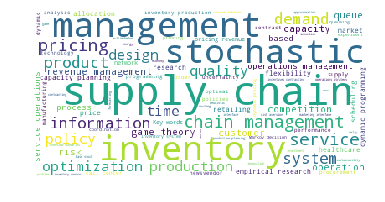

In [11]:
# Fig. 3
# Generate word cloud using text from KEYWORDS
strings = ' '.join(df_msom['keywords'])
generate_wordcloud(strings)

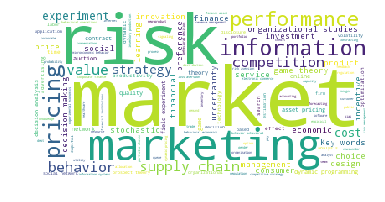

In [12]:
# Fig.4 
strings = ' '.join(df_mnsc['keywords'])
generate_wordcloud(strings)

Next, we repeat the procedure but generated word clouds using text from the abstracts of the papers from both journals separately. The word clouds are shown in Figures 5 and 6. For the MSOM journal, topics are typically related to “cost”, “demand”, “customer”, “product, “customer”, “optimal”, “decision”, “price”, and “retailer”, to name a few. For the second journal, common words and expressions used are: “product”, “firm”, “effect”, “market”, “information”, “consumer”, “decision”, “value”, and “individual”.

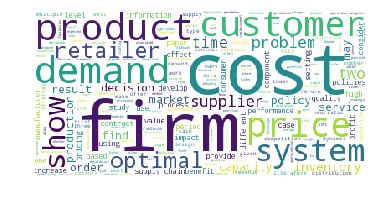

In [9]:
# Fig. 5
strings = ' '.join(df_msom['abstract'])
generate_wordcloud(strings)

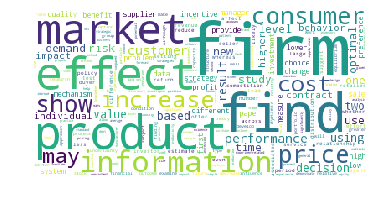

In [10]:
# Fig. 6
strings = ' '.join(df_mnsc['abstract'])
generate_wordcloud(strings)

Publication process in journals with high impact factor are frequently peer-reviewed. Therefore, have people with more experience or knowledge in specific areas that are covered by the target journal can help in all phases of publication process. With that in mind, we generate a network cloud seeking to show how the authors are collaborating to each other. 

Figures 7 shows the collaboration between authors that published in the MSOM journal, where the circle’s sizes represent the total number of publications. We can see a large interconnected group of people in the center of the plot. Figure 8 shows for MNSC.

/Users/veronezi.pedro/anaconda/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/veronezi.pedro/anaconda/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/veronezi.pedro/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/veronezi.pedro/anaconda/lib/python2.7/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 

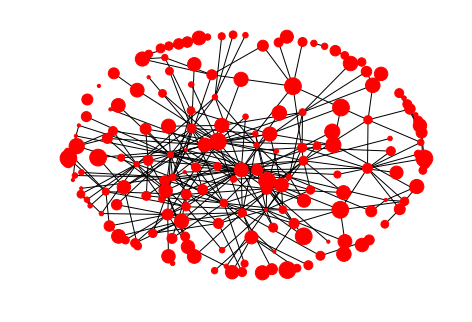

In [13]:
# Fig. 7
# Create network dataframe
network_data = create_network_data_university(df_msom)
generate_network_plot_univ(network_data, False)

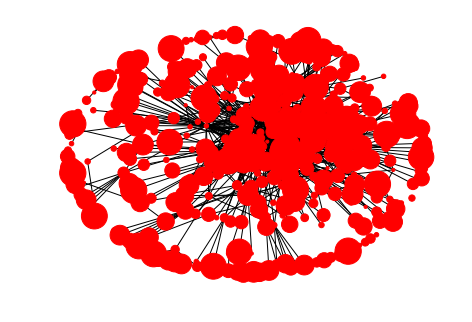

In [14]:
# Fig. 8
network_data = create_network_data_university(df_mnsc)
generate_network_plot_univ(network_data, False)